ターゲットエンコーディング（scikit-learnのcontribモジュール に実装されているようなもの）は、特に高カーディナリティ（値の種類が非常に多い）カテゴリ特徴量をエンコードする上で非常に有用です。

この実装は、ターゲット変数が順序尺度（ordinal）であることを前提としています（このケースではバイナリ分類なので当てはまりますが、多クラス分類の場合は必ずしもそうではありません）。

ここでは、すべての特徴量に対してターゲットエンコーディングを最初の手法として使用していますが、多くの特徴量にとっては、他のエンコーディング手法のほうが予測性能を高める可能性があります。

データリークを防ぐためにk-fold（k分割交差検証）を使用しています。

 さもなければ、ほぼ確実に過学習が起きてしまうからです。代替として、学習データを分割するという手もありますが、データセットのサイズが小さいため、リサンプリング技術（再抽出法）を使う方が望ましいと考えられます。

※補足：これは kaggle.com/merckel/target-encoding のノートブックを修正したものであり、logit法の代わりにLightGBMが使われています。


### 1.EDA

In [16]:
import pandas as pd
import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder

In [17]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.sort_index(inplace=True)

In [18]:
train.target

0         0
1         0
2         0
3         1
4         0
         ..
299995    0
299996    0
299997    1
299998    1
299999    0
Name: target, Length: 300000, dtype: int64

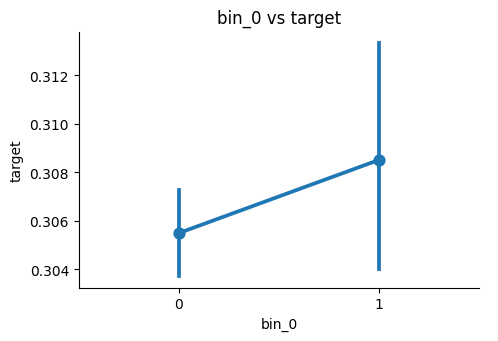

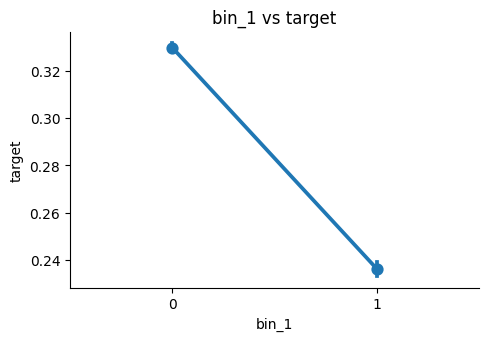

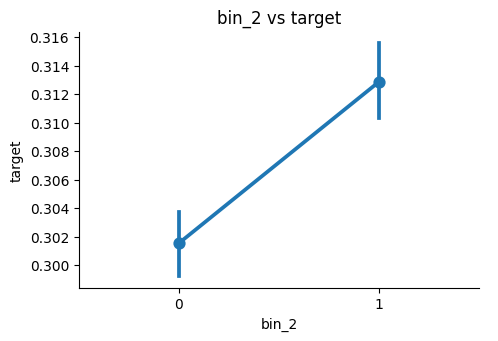

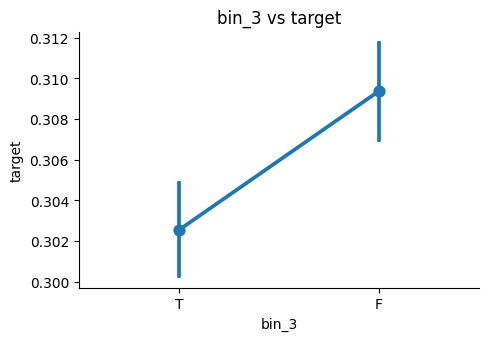

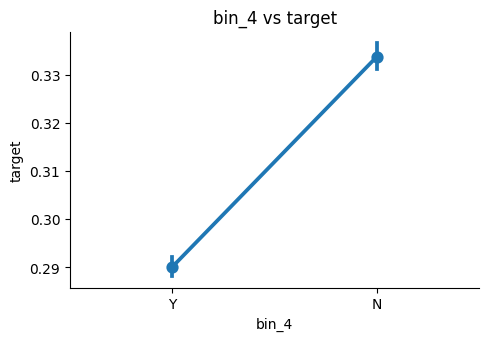

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# bin_0 〜 bin_9 を繰り返し処理
for i in range(5):
    col = f'bin_{i}'
    sns.catplot(x=col, y='target', data=train, kind='point')
    plt.gcf().set_size_inches(5, 3)
    plt.title(f'{col} vs target')
    plt.show()

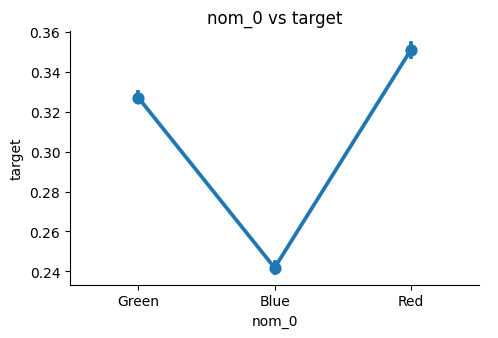

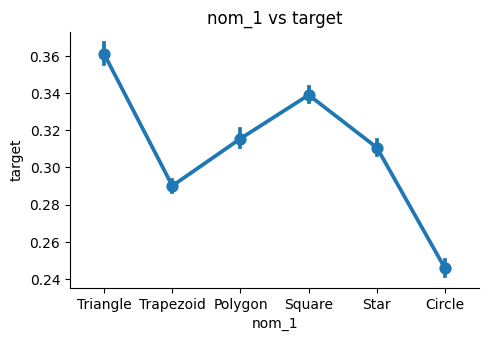

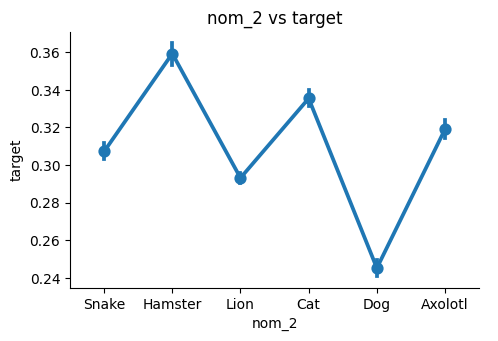

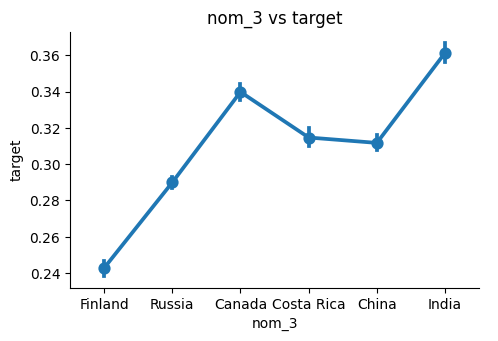

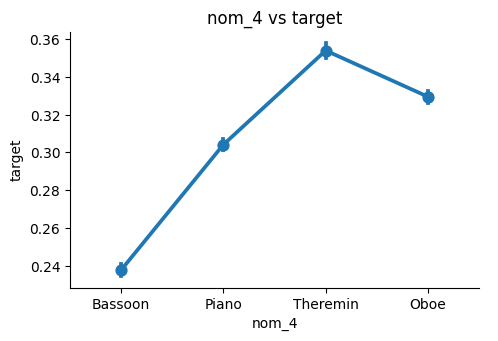

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(5):
    col = f'nom_{i}'
    sns.catplot(x=col, y='target', data=train, kind='point')
    plt.gcf().set_size_inches(5, 3)
    plt.title(f'{col} vs target')
    plt.show()

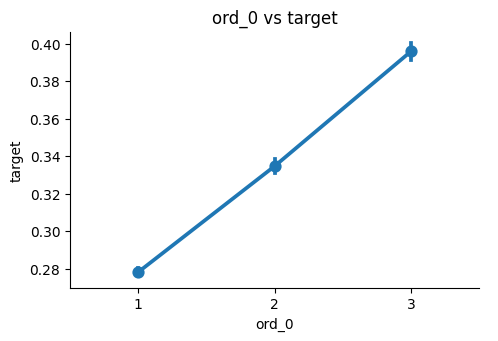

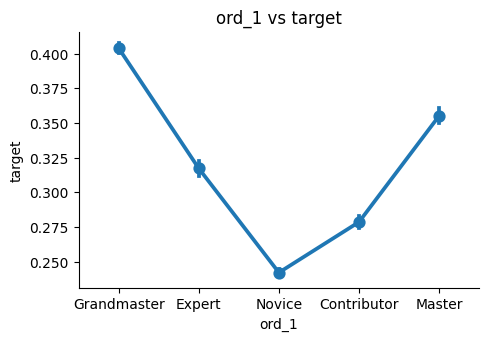

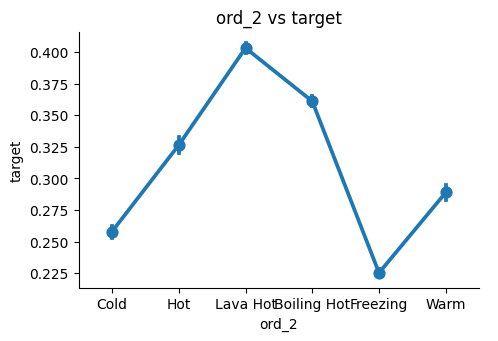

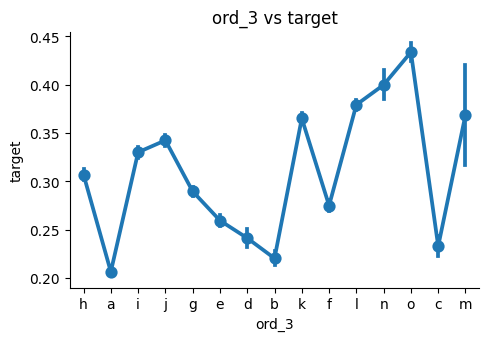

In [21]:
for i in range(4):
    col = f'ord_{i}'
    sns.catplot(x=col, y='target', data=train, kind='point')
    plt.gcf().set_size_inches(5, 3)
    plt.title(f'{col} vs target')
    plt.show()

In [22]:
train_y = train['target']
test_id = test['id']
train.drop(['target', 'id'], axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [23]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary


resumetable(train)

Dataset Shape: (300000, 23)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,bin_0,int64,0,2,0,0,0,0.55
1,bin_1,int64,0,2,0,1,0,0.82
2,bin_2,int64,0,2,0,0,0,0.96
3,bin_3,object,0,2,T,T,F,1.00
4,bin_4,object,0,2,Y,Y,Y,0.94
5,nom_0,object,0,3,Green,Green,Blue,1.55
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid,2.45
7,nom_2,object,0,6,Snake,Hamster,Lion,2.44
8,nom_3,object,0,6,Finland,Russia,Russia,2.45
9,nom_4,object,0,4,Bassoon,Piano,Theremin,1.97


In [24]:
train_y.head(10)

0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: target, dtype: int64

In [25]:
missing_counts = train.isna().sum()

C:\Users\tatib\AppData\Local\Temp\ipykernel_15092\1370055212.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='column', y='missing_count', palette=palette)


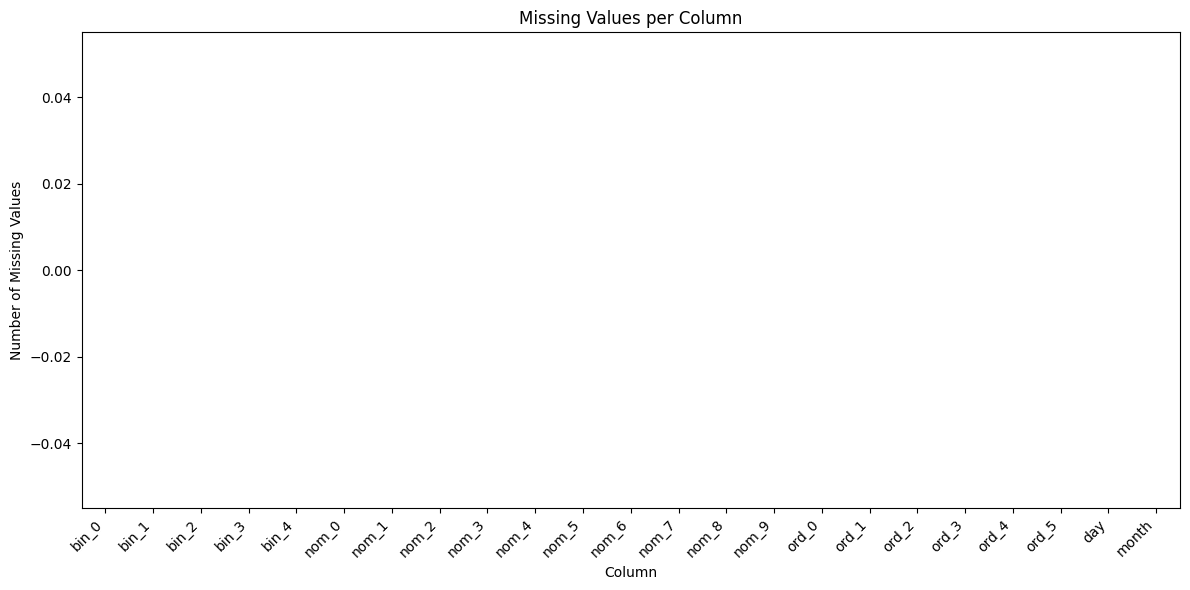

In [26]:
missing_df = missing_counts.reset_index()
missing_df.columns = ['column', 'missing_count']
# プロット
plt.figure(figsize=(12, 6))
palette = sns.color_palette("husl", len(missing_df))  # 異なる色を指定
sns.barplot(data=missing_df, x='column', y='missing_count', palette=palette)

plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.Target Encoding and LightGBM

Target Encoding（Target Mean Encoding）とはカテゴリカル（質的）データを数値に変換する方法の1つです。

様々な手法があるのですが、Target Encodingの一番の特徴は目的変数を使用するという点です。

筆者の言葉で誤解を恐れずに言うのであればTarget Encodingが生み出すのは「値が大きいほど目的変数の値も大きい確率が高い」特徴量ということになります。

目的変数という答えを利用するTarget Encodingはデータセットによっては非常に強力な力を持ちます。

ターゲットエンコーディングをStratified K-Fold交差検証を使って行う例であり、情報リーク（data leakage）を防ぎつつ、高カーディナリティのカテゴリ変数を変換する目的で使われています。

In [27]:
cat_feat_to_encode = train.columns.tolist()
smoothing=50.0

oof_list = []  # 最初にリストを作る

for tr_idx, oof_idx in StratifiedKFold(
    n_splits=5, 
    random_state=1, 
    shuffle=True).split(train, train_y):
    
    ce_target_encoder = ce.TargetEncoder(cols=cat_feat_to_encode, smoothing=smoothing)
    ce_target_encoder.fit(train.iloc[tr_idx, :], train_y.iloc[tr_idx])
    
    # appendじゃなくてリストに貯める！
    oof_list.append(ce_target_encoder.transform(train.iloc[oof_idx, :]))

# ループが終わったら一括でconcat
oof = pd.concat(oof_list, axis=0)

# あとは同じ
ce_target_encoder = ce.TargetEncoder(cols=cat_feat_to_encode, smoothing=smoothing)
ce_target_encoder.fit(train, train_y)

train = oof.sort_index()
test = ce_target_encoder.transform(test)


- `cat_feat_to_encode`：
  - `train` のすべての列をターゲットエンコーディングの対象にしています（本来はカテゴリ変数だけにするのが適切）。

- `smoothing=50.0`：
  - **平滑化の係数**です。ターゲットエンコーディングの式：

    $$
    \hat{y}_{\text{カテゴリ}} = \frac{n \cdot \bar{y}_{\text{カテゴリ}} + \text{smoothing} \cdot \bar{y}_{\text{全体}}}{n + \text{smoothing}}
    $$

    - $n$：そのカテゴリの出現数  
    - $\bar{y}_{\text{カテゴリ}}$：そのカテゴリのターゲット平均  
    - $\bar{y}_{\text{全体}}$：全体のターゲット平均  

    ⇒ smoothing が大きいほど「全体平均」に寄ります（過学習抑制）


In [28]:
clf = lgb.train(
    params={
        'max_depth': 2, 
        'num_leaves': 150,
        'reg_alpha': 0.6, 
        'reg_lambda': 0.6,
        'objective': 'binary',
        "boosting_type": "gbdt",
        "metric": 'auc',
        "verbosity": -1,
        'random_state': 1},
    train_set=lgb.Dataset(train, label=train_y),
    num_boost_round=700)

In [29]:
from datetime import datetime
pd.DataFrame({'id': test_id, 'target': clf.predict(test)}).to_csv(
    'sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', 
    index=False)

In [32]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

def objective(trial):
    # チューニングするパラメータを定義
    param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 1,
        'device': 'gpu',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    }
    
    # 5-foldで交差検証
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    aucs = []
    
    for tr_idx, val_idx in cv.split(train, train_y):
        trn_data = lgb.Dataset(train.iloc[tr_idx], label=train_y.iloc[tr_idx])
        val_data = lgb.Dataset(train.iloc[val_idx], label=train_y.iloc[val_idx])
        model = lgb.train(
            params=param,
            train_set=trn_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(0)  # verbose_eval=False 相当
            ])
        
        preds = model.predict(train.iloc[val_idx])
        auc = roc_auc_score(train_y.iloc[val_idx], preds)
        aucs.append(auc)

    return np.mean(aucs)

# Optunaでチューニング開始！
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# ベストパラメータ表示
print("Best params:", study.best_params)
print("Best AUC:", study.best_value)


[I 2025-04-28 14:56:44,622] A new study created in memory with name: no-name-4c91362b-e318-435c-982f-82844bef0a17


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's auc: 0.803472
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's auc: 0.801626
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's auc: 0.800062
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.800355
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.800029


[I 2025-04-28 14:57:07,591] Trial 0 finished with value: 0.8011087555003836 and parameters: {'max_depth': 1, 'num_leaves': 442, 'reg_alpha': 0.1565310685372986, 'reg_lambda': 0.6063630255777696, 'min_child_samples': 34, 'learning_rate': 0.13069723675731745}. Best is trial 0 with value: 0.8011087555003836.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's auc: 0.80004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[509]	valid_0's auc: 0.797732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	valid_0's auc: 0.795967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[604]	valid_0's auc: 0.795997
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's auc: 0.795501


[I 2025-04-28 14:57:47,398] Trial 1 finished with value: 0.7970473692460469 and parameters: {'max_depth': 6, 'num_leaves': 174, 'reg_alpha': 0.22372873994364073, 'reg_lambda': 0.5360652363945382, 'min_child_samples': 92, 'learning_rate': 0.03343248397304015}. Best is trial 0 with value: 0.8011087555003836.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid_0's auc: 0.801061
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[551]	valid_0's auc: 0.799453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[438]	valid_0's auc: 0.797579
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[553]	valid_0's auc: 0.798258
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:58:01,959] Trial 2 finished with value: 0.7988648715685307 and parameters: {'max_depth': 3, 'num_leaves': 465, 'reg_alpha': 0.1416555081656281, 'reg_lambda': 0.7472585759513918, 'min_child_samples': 33, 'learning_rate': 0.10363888700989583}. Best is trial 0 with value: 0.8011087555003836.


Early stopping, best iteration is:
[514]	valid_0's auc: 0.797973
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.803525
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.801657
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's auc: 0.800103
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.800463
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.800084


[I 2025-04-28 14:58:18,732] Trial 3 finished with value: 0.8011663966313305 and parameters: {'max_depth': 1, 'num_leaves': 91, 'reg_alpha': 0.4160206495341763, 'reg_lambda': 0.5200915897884986, 'min_child_samples': 21, 'learning_rate': 0.14940629227859065}. Best is trial 3 with value: 0.8011663966313305.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.796564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.794056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.792187
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.792558
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:58:34,545] Trial 4 finished with value: 0.7936967168790721 and parameters: {'max_depth': 7, 'num_leaves': 100, 'reg_alpha': 0.6860312635255391, 'reg_lambda': 0.4256723424074398, 'min_child_samples': 22, 'learning_rate': 0.13788180384077078}. Best is trial 3 with value: 0.8011663966313305.


Early stopping, best iteration is:
[107]	valid_0's auc: 0.793118
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.800765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[286]	valid_0's auc: 0.798638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.79693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.797666
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:58:43,618] Trial 5 finished with value: 0.7981929438756935 and parameters: {'max_depth': 3, 'num_leaves': 339, 'reg_alpha': 0.2155994122015904, 'reg_lambda': 0.6250429194044481, 'min_child_samples': 87, 'learning_rate': 0.20007354320638718}. Best is trial 3 with value: 0.8011663966313305.


Early stopping, best iteration is:
[257]	valid_0's auc: 0.796965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.797975
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.796223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.794128
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.794578
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:58:50,978] Trial 6 finished with value: 0.7954238385910148 and parameters: {'max_depth': 4, 'num_leaves': 52, 'reg_alpha': 0.5602518836950564, 'reg_lambda': 0.9185797214980905, 'min_child_samples': 87, 'learning_rate': 0.2932149218954898}. Best is trial 3 with value: 0.8011663966313305.


Early stopping, best iteration is:
[114]	valid_0's auc: 0.794215
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[552]	valid_0's auc: 0.800944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[680]	valid_0's auc: 0.799003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[581]	valid_0's auc: 0.797255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[807]	valid_0's auc: 0.797458
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[512]	valid_0's auc: 0.797177


[I 2025-04-28 14:59:14,109] Trial 7 finished with value: 0.7983674755532036 and parameters: {'max_depth': 4, 'num_leaves': 72, 'reg_alpha': 0.8631754446317782, 'reg_lambda': 0.006519502343907968, 'min_child_samples': 39, 'learning_rate': 0.052202204670586415}. Best is trial 3 with value: 0.8011663966313305.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's auc: 0.801123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's auc: 0.79869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's auc: 0.79715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[348]	valid_0's auc: 0.797985
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:59:23,356] Trial 8 finished with value: 0.7985178674254991 and parameters: {'max_depth': 3, 'num_leaves': 240, 'reg_alpha': 0.5102657477036214, 'reg_lambda': 0.8222272819429548, 'min_child_samples': 27, 'learning_rate': 0.1716070917232771}. Best is trial 3 with value: 0.8011663966313305.


Early stopping, best iteration is:
[283]	valid_0's auc: 0.797642
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.797829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.795752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.793923
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.793912
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:59:37,228] Trial 9 finished with value: 0.7950106721663397 and parameters: {'max_depth': 6, 'num_leaves': 474, 'reg_alpha': 0.747389687623645, 'reg_lambda': 0.4390671354354616, 'min_child_samples': 5, 'learning_rate': 0.13716893970683547}. Best is trial 3 with value: 0.8011663966313305.


Early stopping, best iteration is:
[123]	valid_0's auc: 0.793637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's auc: 0.799141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid_0's auc: 0.797175
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.794898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.796258
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:59:43,845] Trial 10 finished with value: 0.7966099553274223 and parameters: {'max_depth': 9, 'num_leaves': 11, 'reg_alpha': 0.3773203228989575, 'reg_lambda': 0.17891887037940446, 'min_child_samples': 52, 'learning_rate': 0.23693062088464487}. Best is trial 3 with value: 0.8011663966313305.


Early stopping, best iteration is:
[127]	valid_0's auc: 0.795578
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.802949
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.800843
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.799478
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.799487
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:59:59,803] Trial 11 finished with value: 0.800423264790189 and parameters: {'max_depth': 1, 'num_leaves': 350, 'reg_alpha': 0.004193289420493129, 'reg_lambda': 0.31729532909692837, 'min_child_samples': 10, 'learning_rate': 0.07918103038406181}. Best is trial 3 with value: 0.8011663966313305.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.79936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[760]	valid_0's auc: 0.803512
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.801727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[842]	valid_0's auc: 0.800082
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.800549
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:00:14,240] Trial 12 finished with value: 0.8011955288562577 and parameters: {'max_depth': 1, 'num_leaves': 367, 'reg_alpha': 0.36434196102284905, 'reg_lambda': 0.6803466643619351, 'min_child_samples': 62, 'learning_rate': 0.20861762162808795}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[835]	valid_0's auc: 0.800108
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[652]	valid_0's auc: 0.803526
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's auc: 0.801735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[650]	valid_0's auc: 0.80005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[846]	valid_0's auc: 0.800544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[770]	valid_0's auc: 0.800044


[I 2025-04-28 15:00:27,572] Trial 13 finished with value: 0.8011798345061509 and parameters: {'max_depth': 1, 'num_leaves': 327, 'reg_alpha': 0.39359257005877, 'reg_lambda': 0.9974439279627617, 'min_child_samples': 63, 'learning_rate': 0.22407270505969967}. Best is trial 12 with value: 0.8011955288562577.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[346]	valid_0's auc: 0.802233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[381]	valid_0's auc: 0.800295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid_0's auc: 0.798207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[377]	valid_0's auc: 0.798955
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:00:36,625] Trial 14 finished with value: 0.7997305173043409 and parameters: {'max_depth': 2, 'num_leaves': 351, 'reg_alpha': 0.3708103123584785, 'reg_lambda': 0.9606773700340859, 'min_child_samples': 67, 'learning_rate': 0.23598371917717517}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[345]	valid_0's auc: 0.798962
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.787886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.78596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.784279
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.784943
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:00:56,249] Trial 15 finished with value: 0.7856746613254298 and parameters: {'max_depth': 10, 'num_leaves': 267, 'reg_alpha': 0.9791360135588122, 'reg_lambda': 0.7641893671698728, 'min_child_samples': 69, 'learning_rate': 0.29963150867146815}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.785305
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.791477
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.790046
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.786979
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.78858
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:01:11,661] Trial 16 finished with value: 0.7891203973382207 and parameters: {'max_depth': 8, 'num_leaves': 383, 'reg_alpha': 0.31219396839162195, 'reg_lambda': 0.9935827843902918, 'min_child_samples': 66, 'learning_rate': 0.24026685284156643}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[45]	valid_0's auc: 0.788521
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.798249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's auc: 0.796006
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.794523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's auc: 0.794777
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:01:20,972] Trial 17 finished with value: 0.795476628819727 and parameters: {'max_depth': 5, 'num_leaves': 269, 'reg_alpha': 0.6321393454915183, 'reg_lambda': 0.8566590336352929, 'min_child_samples': 52, 'learning_rate': 0.19265580233774596}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[119]	valid_0's auc: 0.793829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[297]	valid_0's auc: 0.80184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's auc: 0.799921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's auc: 0.79806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid_0's auc: 0.799169
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:01:30,008] Trial 18 finished with value: 0.7994614236500632 and parameters: {'max_depth': 2, 'num_leaves': 411, 'reg_alpha': 0.4686384826429413, 'reg_lambda': 0.6812412589236113, 'min_child_samples': 76, 'learning_rate': 0.26227807334474074}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[329]	valid_0's auc: 0.798318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid_0's auc: 0.802273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[407]	valid_0's auc: 0.800199
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[402]	valid_0's auc: 0.798788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[502]	valid_0's auc: 0.7991
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:01:40,670] Trial 19 finished with value: 0.7997975865263363 and parameters: {'max_depth': 2, 'num_leaves': 310, 'reg_alpha': 0.04042450555634358, 'reg_lambda': 0.8820945218884974, 'min_child_samples': 45, 'learning_rate': 0.1981781240994909}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[388]	valid_0's auc: 0.798629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.798256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's auc: 0.795556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[131]	valid_0's auc: 0.794597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.795434
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:01:47,287] Trial 20 finished with value: 0.7957823176186268 and parameters: {'max_depth': 4, 'num_leaves': 194, 'reg_alpha': 0.2898501574180714, 'reg_lambda': 0.3003934641226735, 'min_child_samples': 78, 'learning_rate': 0.2644111105847896}. Best is trial 12 with value: 0.8011955288562577.


Early stopping, best iteration is:
[124]	valid_0's auc: 0.795068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[910]	valid_0's auc: 0.803504
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.801708
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's auc: 0.800085
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.800506
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.800109


[I 2025-04-28 15:02:03,175] Trial 21 finished with value: 0.8011822741006437 and parameters: {'max_depth': 1, 'num_leaves': 199, 'reg_alpha': 0.34547710945333027, 'reg_lambda': 0.545342413103491, 'min_child_samples': 61, 'learning_rate': 0.16889882964548456}. Best is trial 12 with value: 0.8011955288562577.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[757]	valid_0's auc: 0.803526
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.801741
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[721]	valid_0's auc: 0.800097
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's auc: 0.800573
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:02:17,410] Trial 22 finished with value: 0.8012060749335068 and parameters: {'max_depth': 1, 'num_leaves': 172, 'reg_alpha': 0.587523778138223, 'reg_lambda': 0.7164044675426907, 'min_child_samples': 59, 'learning_rate': 0.21523724836149202}. Best is trial 22 with value: 0.8012060749335068.


Early stopping, best iteration is:
[716]	valid_0's auc: 0.800094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	valid_0's auc: 0.802382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[463]	valid_0's auc: 0.800441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[462]	valid_0's auc: 0.798569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[662]	valid_0's auc: 0.799387
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:02:29,762] Trial 23 finished with value: 0.7999069474105797 and parameters: {'max_depth': 2, 'num_leaves': 150, 'reg_alpha': 0.5835272035649749, 'reg_lambda': 0.7070714775674257, 'min_child_samples': 58, 'learning_rate': 0.17174930845938566}. Best is trial 22 with value: 0.8012060749335068.


Early stopping, best iteration is:
[511]	valid_0's auc: 0.798755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[758]	valid_0's auc: 0.803518
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.801739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[725]	valid_0's auc: 0.800094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[845]	valid_0's auc: 0.800547
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:02:44,364] Trial 24 finished with value: 0.8012057088194597 and parameters: {'max_depth': 1, 'num_leaves': 221, 'reg_alpha': 0.757891226908169, 'reg_lambda': 0.6164866849749346, 'min_child_samples': 78, 'learning_rate': 0.21467986477353065}. Best is trial 22 with value: 0.8012060749335068.


Did not meet early stopping. Best iteration is:
[974]	valid_0's auc: 0.800131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[194]	valid_0's auc: 0.800423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.798551
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.796955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[221]	valid_0's auc: 0.797961
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:02:52,248] Trial 25 finished with value: 0.7982270563832425 and parameters: {'max_depth': 3, 'num_leaves': 141, 'reg_alpha': 0.7904672954590634, 'reg_lambda': 0.6356586651169396, 'min_child_samples': 78, 'learning_rate': 0.20898544139300326}. Best is trial 22 with value: 0.8012060749335068.


Early stopping, best iteration is:
[224]	valid_0's auc: 0.797246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's auc: 0.802183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's auc: 0.799518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.798214
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's auc: 0.798748
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:03:01,249] Trial 26 finished with value: 0.7995139338020556 and parameters: {'max_depth': 2, 'num_leaves': 231, 'reg_alpha': 0.8651050454101407, 'reg_lambda': 0.7927229319003535, 'min_child_samples': 73, 'learning_rate': 0.2676709983774656}. Best is trial 22 with value: 0.8012060749335068.


Early stopping, best iteration is:
[310]	valid_0's auc: 0.798907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.797775
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.796224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.793769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.793628
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:03:09,587] Trial 27 finished with value: 0.7950888203344 and parameters: {'max_depth': 5, 'num_leaves': 289, 'reg_alpha': 0.6792184982272225, 'reg_lambda': 0.4336607793888009, 'min_child_samples': 44, 'learning_rate': 0.21516039857688182}. Best is trial 22 with value: 0.8012060749335068.


Early stopping, best iteration is:
[105]	valid_0's auc: 0.794047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[739]	valid_0's auc: 0.803511
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.801742
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[720]	valid_0's auc: 0.800086
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.800552
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[957]	valid_0's auc: 0.800134


[I 2025-04-28 15:03:23,792] Trial 28 finished with value: 0.8012048926547332 and parameters: {'max_depth': 1, 'num_leaves': 212, 'reg_alpha': 0.5094701248618385, 'reg_lambda': 0.717578437537247, 'min_child_samples': 97, 'learning_rate': 0.186113258524911}. Best is trial 22 with value: 0.8012060749335068.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[889]	valid_0's auc: 0.803525
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.801734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[860]	valid_0's auc: 0.800118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.800548
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.800113


[I 2025-04-28 15:03:40,962] Trial 29 finished with value: 0.8012076616380102 and parameters: {'max_depth': 1, 'num_leaves': 124, 'reg_alpha': 0.5044165069073598, 'reg_lambda': 0.5895254908929914, 'min_child_samples': 98, 'learning_rate': 0.1751024581379656}. Best is trial 29 with value: 0.8012076616380102.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[688]	valid_0's auc: 0.802403
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[851]	valid_0's auc: 0.80051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[692]	valid_0's auc: 0.798761
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's auc: 0.799423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[778]	valid_0's auc: 0.798821


[I 2025-04-28 15:03:57,612] Trial 30 finished with value: 0.7999837262404206 and parameters: {'max_depth': 2, 'num_leaves': 148, 'reg_alpha': 0.7815792088916643, 'reg_lambda': 0.6263295021233259, 'min_child_samples': 98, 'learning_rate': 0.09182068437937067}. Best is trial 29 with value: 0.8012076616380102.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[867]	valid_0's auc: 0.803515
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.801722
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.800116
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.800528
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:04:12,656] Trial 31 finished with value: 0.8011791622318615 and parameters: {'max_depth': 1, 'num_leaves': 222, 'reg_alpha': 0.5378169514457136, 'reg_lambda': 0.570755924192421, 'min_child_samples': 96, 'learning_rate': 0.1722590482440093}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[719]	valid_0's auc: 0.800016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[719]	valid_0's auc: 0.803506
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.801734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[646]	valid_0's auc: 0.800013
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's auc: 0.800569
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:04:26,797] Trial 32 finished with value: 0.8011774367869815 and parameters: {'max_depth': 1, 'num_leaves': 123, 'reg_alpha': 0.4675323928599559, 'reg_lambda': 0.7054033598493239, 'min_child_samples': 85, 'learning_rate': 0.1905457352068279}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[721]	valid_0's auc: 0.800064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[444]	valid_0's auc: 0.802271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[621]	valid_0's auc: 0.800256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[476]	valid_0's auc: 0.798598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[708]	valid_0's auc: 0.799141
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:04:38,497] Trial 33 finished with value: 0.7998340461117385 and parameters: {'max_depth': 2, 'num_leaves': 173, 'reg_alpha': 0.6126251848603843, 'reg_lambda': 0.4705520402221378, 'min_child_samples': 100, 'learning_rate': 0.15568737898743665}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[534]	valid_0's auc: 0.798904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[405]	valid_0's auc: 0.801093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[420]	valid_0's auc: 0.799154
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid_0's auc: 0.797871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[466]	valid_0's auc: 0.798188
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:04:50,594] Trial 34 finished with value: 0.7987757418673244 and parameters: {'max_depth': 3, 'num_leaves': 191, 'reg_alpha': 0.6705778156088011, 'reg_lambda': 0.5741002728459084, 'min_child_samples': 93, 'learning_rate': 0.11700835494697867}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[465]	valid_0's auc: 0.797573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[719]	valid_0's auc: 0.80351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[704]	valid_0's auc: 0.801659
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[967]	valid_0's auc: 0.80009
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's auc: 0.800551
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:05:04,119] Trial 35 finished with value: 0.801170676530416 and parameters: {'max_depth': 1, 'num_leaves': 111, 'reg_alpha': 0.4629420727664063, 'reg_lambda': 0.7453181635968953, 'min_child_samples': 84, 'learning_rate': 0.18877191312471694}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[718]	valid_0's auc: 0.800044
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.800502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[217]	valid_0's auc: 0.798354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.796608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[247]	valid_0's auc: 0.797372
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:05:11,670] Trial 36 finished with value: 0.797941022004495 and parameters: {'max_depth': 3, 'num_leaves': 171, 'reg_alpha': 0.7344775012092191, 'reg_lambda': 0.3591907368074625, 'min_child_samples': 91, 'learning_rate': 0.22885099387591654}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[240]	valid_0's auc: 0.796869
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's auc: 0.803517
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.801704
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's auc: 0.80007
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.80048
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.800096


[I 2025-04-28 15:05:27,421] Trial 37 finished with value: 0.8011731291218552 and parameters: {'max_depth': 1, 'num_leaves': 216, 'reg_alpha': 0.5421959599870542, 'reg_lambda': 0.5168921966924804, 'min_child_samples': 83, 'learning_rate': 0.15432753547644476}. Best is trial 29 with value: 0.8012076616380102.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.794833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.793047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.789982
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.791703
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:05:37,264] Trial 38 finished with value: 0.7920127586710941 and parameters: {'max_depth': 7, 'num_leaves': 75, 'reg_alpha': 0.8637162659806379, 'reg_lambda': 0.6171782757262944, 'min_child_samples': 90, 'learning_rate': 0.24661860933762292}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[54]	valid_0's auc: 0.790499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.798436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.796749
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.794367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.795949
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:05:44,614] Trial 39 finished with value: 0.7959502578004714 and parameters: {'max_depth': 4, 'num_leaves': 32, 'reg_alpha': 0.6167908386054486, 'reg_lambda': 0.8306908020502326, 'min_child_samples': 95, 'learning_rate': 0.25414746342916517}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[124]	valid_0's auc: 0.79425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's auc: 0.802388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[536]	valid_0's auc: 0.800093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[680]	valid_0's auc: 0.798857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[722]	valid_0's auc: 0.799294
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:05:58,779] Trial 40 finished with value: 0.7998836098937978 and parameters: {'max_depth': 2, 'num_leaves': 254, 'reg_alpha': 0.4266818686494676, 'reg_lambda': 0.7485022262408358, 'min_child_samples': 72, 'learning_rate': 0.12015243335343115}. Best is trial 29 with value: 0.8012076616380102.


Early stopping, best iteration is:
[710]	valid_0's auc: 0.798786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[723]	valid_0's auc: 0.803509
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.801744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[775]	valid_0's auc: 0.800083
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.800597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[889]	valid_0's auc: 0.800125


[I 2025-04-28 15:06:13,992] Trial 41 finished with value: 0.8012117751170538 and parameters: {'max_depth': 1, 'num_leaves': 494, 'reg_alpha': 0.15542573694584377, 'reg_lambda': 0.6636238213383244, 'min_child_samples': 56, 'learning_rate': 0.21965765528947304}. Best is trial 41 with value: 0.8012117751170538.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[824]	valid_0's auc: 0.803361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[847]	valid_0's auc: 0.801664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[602]	valid_0's auc: 0.800018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[790]	valid_0's auc: 0.8005
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:06:26,740] Trial 42 finished with value: 0.801118375321358 and parameters: {'max_depth': 1, 'num_leaves': 487, 'reg_alpha': 0.1351290876888412, 'reg_lambda': 0.6643900515008949, 'min_child_samples': 46, 'learning_rate': 0.2825747754543231}. Best is trial 41 with value: 0.8012117751170538.


Early stopping, best iteration is:
[697]	valid_0's auc: 0.800049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[411]	valid_0's auc: 0.802059
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[499]	valid_0's auc: 0.80018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[386]	valid_0's auc: 0.798125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid_0's auc: 0.798753
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:06:36,087] Trial 43 finished with value: 0.799492806526927 and parameters: {'max_depth': 2, 'num_leaves': 456, 'reg_alpha': 0.26766742984811476, 'reg_lambda': 0.5902699284958229, 'min_child_samples': 57, 'learning_rate': 0.21808905581833338}. Best is trial 41 with value: 0.8012117751170538.


Early stopping, best iteration is:
[405]	valid_0's auc: 0.798348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[721]	valid_0's auc: 0.803502
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's auc: 0.801738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[888]	valid_0's auc: 0.800096
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.800556
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:06:50,117] Trial 44 finished with value: 0.8012028916771214 and parameters: {'max_depth': 1, 'num_leaves': 426, 'reg_alpha': 0.516453697280477, 'reg_lambda': 0.49067992322367454, 'min_child_samples': 80, 'learning_rate': 0.18567325093269554}. Best is trial 41 with value: 0.8012117751170538.


Early stopping, best iteration is:
[863]	valid_0's auc: 0.800123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[225]	valid_0's auc: 0.800231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's auc: 0.798505
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.797607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's auc: 0.797945
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:06:57,721] Trial 45 finished with value: 0.7983076240746149 and parameters: {'max_depth': 3, 'num_leaves': 301, 'reg_alpha': 0.21451544746258192, 'reg_lambda': 0.8065837814356338, 'min_child_samples': 37, 'learning_rate': 0.2060703389992209}. Best is trial 41 with value: 0.8012117751170538.


Early stopping, best iteration is:
[245]	valid_0's auc: 0.79725
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.785651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.783711
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.783154
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.782115
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.78235


[I 2025-04-28 15:07:12,661] Trial 46 finished with value: 0.7833963920024097 and parameters: {'max_depth': 1, 'num_leaves': 89, 'reg_alpha': 0.5702575920132634, 'reg_lambda': 0.7309466758034859, 'min_child_samples': 100, 'learning_rate': 0.018086941768508447}. Best is trial 41 with value: 0.8012117751170538.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid_0's auc: 0.802346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[464]	valid_0's auc: 0.800065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[548]	valid_0's auc: 0.798309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[492]	valid_0's auc: 0.799354
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:07:22,562] Trial 47 finished with value: 0.7998015765173948 and parameters: {'max_depth': 2, 'num_leaves': 246, 'reg_alpha': 0.7267572369639601, 'reg_lambda': 0.9039992147211166, 'min_child_samples': 89, 'learning_rate': 0.17931284526566138}. Best is trial 41 with value: 0.8012117751170538.


Early stopping, best iteration is:
[457]	valid_0's auc: 0.798933
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.803498
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.801657
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.800142
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.80043
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's auc: 0.800094


[I 2025-04-28 15:07:37,648] Trial 48 finished with value: 0.8011643225439912 and parameters: {'max_depth': 1, 'num_leaves': 167, 'reg_alpha': 0.09463453556399015, 'reg_lambda': 0.5615226138674075, 'min_child_samples': 30, 'learning_rate': 0.1443187818470575}. Best is trial 41 with value: 0.8012117751170538.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.799126
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.797567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's auc: 0.795257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's auc: 0.795109
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 15:07:44,706] Trial 49 finished with value: 0.7964844196442586 and parameters: {'max_depth': 4, 'num_leaves': 123, 'reg_alpha': 0.9276598333210542, 'reg_lambda': 0.6921784361071477, 'min_child_samples': 56, 'learning_rate': 0.22463724122168835}. Best is trial 41 with value: 0.8012117751170538.


Early stopping, best iteration is:
[149]	valid_0's auc: 0.795364
Best params: {'max_depth': 1, 'num_leaves': 494, 'reg_alpha': 0.15542573694584377, 'reg_lambda': 0.6636238213383244, 'min_child_samples': 56, 'learning_rate': 0.21965765528947304}
Best AUC: 0.8012117751170538


In [33]:
# 1. ベストパラメータを取得
best_params = study.best_params

# 2. 固定パラメータを追加
best_params.update({
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'verbosity': -1,
    'random_state': 1
})

# 3. clfを再学習
clf = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(train, label=train_y),
    num_boost_round=700
)

In [34]:
from datetime import datetime
pd.DataFrame({'id': test_id, 'target': clf.predict(test)}).to_csv(
    'sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', 
    index=False)